In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p /content/drive/MyDrive/Text_Analytics_Output

In [6]:
!pip install -q transformers datasets torch accelerate sentence-transformers bertopic umap-learn hdbscan wordcloud polars seaborn scikit-learn faiss-gpu-cu12 bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 10.9 MB/s eta 0:00:00


In [7]:
import faiss
print(faiss.__version__)  # Should print ~1.8.x without errors
print("GPU support:", faiss.get_num_gpus() > 0)  # True on T4/A100

1.13.0
GPU support: True


In [8]:
import os
import gc
import re
import ctypes
import random
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

2. Config & Seed

In [14]:
config = {
    'SEED': 2024,
    'VER': 1,
    'BASE_PATH': '/content/drive/MyDrive/Text Analytics/',  # CHANGE IF YOUR FOLDER NAME IS DIFFERENT
    'PRESET': 'microsoft/deberta-v3-xsmall',
    'MAX_LEN': 256,
    'TRAIN_BATCH': 4,
    'EVAL_BATCH': 8,
    'EPOCHS': 2,
    'FREEZING_EMBEDDINGS': True,
    'FREEZE_LAYERS': 1,
}

def seed_everything():
    random.seed(config['SEED'])
    os.environ['PYTHONHASHSEED'] = str(config['SEED'])
    np.random.seed(config['SEED'])
    torch.manual_seed(config['SEED'])
    torch.cuda.manual_seed_all(config['SEED'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

3. Load Data

In [15]:
df_train = pd.read_csv(config['BASE_PATH'] + 'train.dat', sep='\t', header=None, on_bad_lines='skip')
df_train.rename(columns={0: 'conditions', 1: 'full_text'}, inplace=True)
df_train = df_train[df_train['conditions'] != 5].reset_index(drop=True)
df_train['label'] = df_train['conditions'] - 1
df_train['essay_id'] = df_train.index.astype(str).map(lambda x: f'000{x}')

print("Train shape:", df_train.shape)
df_train.head()

Train shape: (9633, 4)


,conditions,full_text,label,essay_id
0,4,Catheterization laboratory events and hospital...,3,0000
1,2,Hyperplastic polyps seen at sigmoidoscopy are ...,1,0001
2,4,Effect of local inhibition of gamma-aminobutyr...,3,0002
3,1,Infection during chronic epidural catheterizat...,0,0003
4,3,Multiple representations contribute to body kn...,2,0004


4. EDA & Visualizations

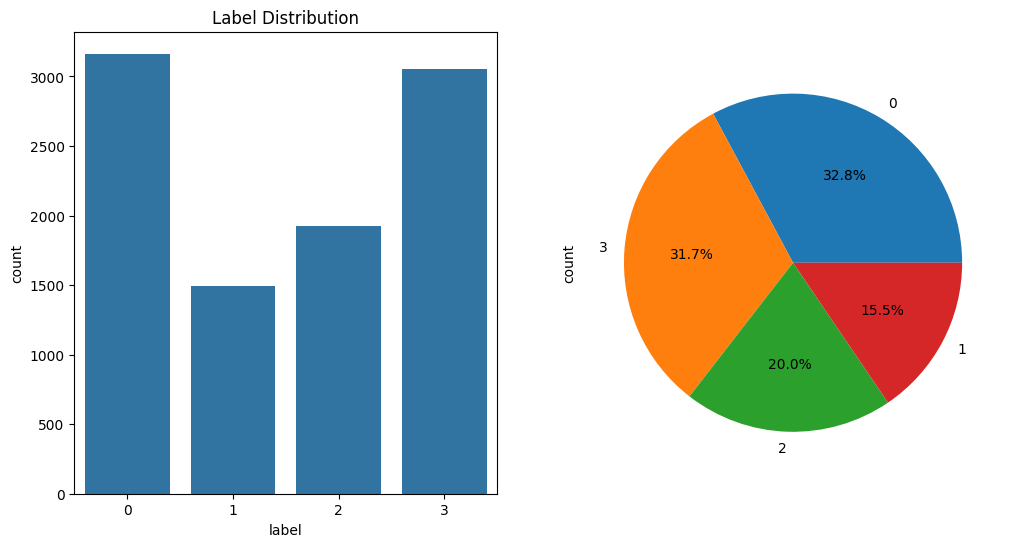

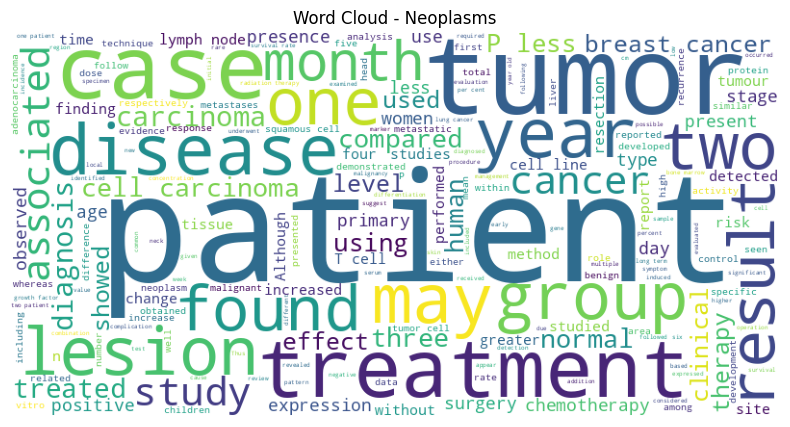

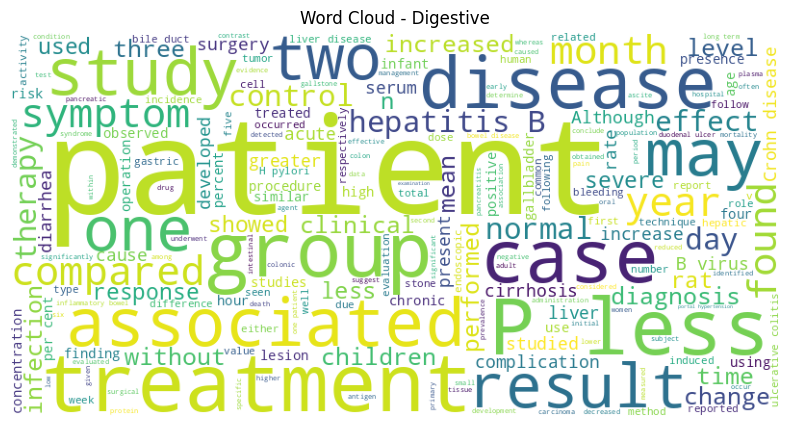

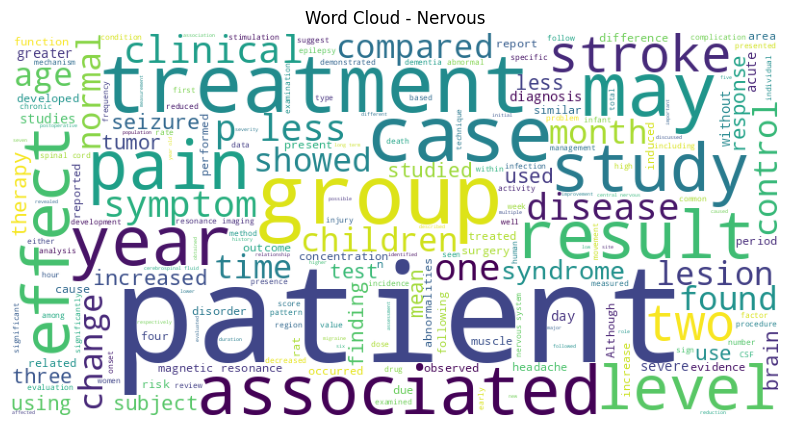

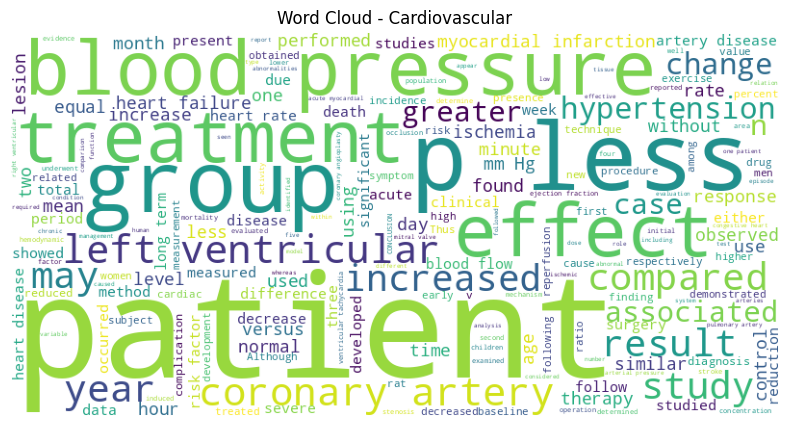

In [16]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(data=df_train, x='label')
plt.title('Label Distribution')
plt.subplot(1,2,2)
df_train['label'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

# Feature Engineering
stop_words = stopwords.words('english')
def create_features(df):
    df['letters'] = df['full_text'].str.len()
    df['words'] = df['full_text'].apply(lambda x: len(x.split()))
    df['unique_words'] = df['full_text'].apply(lambda x: len(set(x.split())))
    df['sentences'] = df['full_text'].apply(lambda x: len(x.split('.')))
    df['stopwords'] = df['full_text'].apply(lambda x: sum(1 for w in x.split() if w.lower() in stop_words))
    df['not_stopwords'] = df['words'] - df['stopwords']
    return df

df_train = create_features(df_train)

# Word Clouds (One example per class)
from wordcloud import WordCloud
labels = ["Neoplasms", "Digestive", "Nervous", "Cardiovascular"]
for i in range(4):
    plt.figure(figsize=(10,5))
    text = " ".join(df_train[df_train['label']==i]['full_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.title(f"Word Cloud - {labels[i]}")
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

5. DeBERTa Training

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config['SEED'])
for fold, (_, val_idx) in enumerate(skf.split(df_train, df_train['label'])):
    df_train.loc[val_idx, 'fold'] = fold

tokenizer = AutoTokenizer.from_pretrained(config['PRESET'])

def tokenize_fn(batch):
    return tokenizer(batch['full_text'], truncation=True, max_length=config['MAX_LEN'])

dataset = Dataset.from_pandas(df_train)
tokenized_dataset = dataset.map(tokenize_fn, batched=True)

# Training Args
training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/Text_Analytics_Output/deberta_v{config['VER']}",
    per_device_train_batch_size=config['TRAIN_BATCH'],
    per_device_eval_batch_size=config['EVAL_BATCH'],
    num_train_epochs=config['EPOCHS'],
    eval_strategy="steps",
    eval_steps=250,
    save_steps=1000,
    logging_steps=250,
    learning_rate=1e-5,
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    save_total_limit=2,
)

all_oof = []
all_true = []

for fold in range(5):
    print(f"\n=== Training Fold {fold} ===")
    train_ds = tokenized_dataset.filter(lambda x: x['fold'] != fold)
    valid_ds = tokenized_dataset.filter(lambda x: x['fold'] == fold)

    model = AutoModelForSequenceClassification.from_pretrained(
        config['PRESET'], num_labels=4
    )
    if config['FREEZING_EMBEDDINGS']:
        for param in model.deberta.embeddings.parameters():
            param.requires_grad = False
    if config['FREEZE_LAYERS'] > 0:
        for layer in model.deberta.encoder.layer[:config['FREEZE_LAYERS']]:
            for param in layer.parameters():
                param.requires_grad = False

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=lambda p: {
            'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1)),
            'f1': f1_score(p.label_ids, p.predictions.argmax(-1), average='weighted')
        }
    )

    trainer.train()
    preds = trainer.predict(valid_ds).predictions.argmax(-1)
    true = valid_ds['label']

    all_oof.extend(preds)
    all_true.extend(true)

    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='weighted')
    print(f"Fold {fold} - Accuracy: {acc:.4f}, F1: {f1:.4f}")

    # Save model
    trainer.save_model(f"/content/drive/MyDrive/Text_Analytics_Output/deberta_fold{fold}")

# Final Score
final_acc = accuracy_score(all_true, all_oof)
final_f1 = f1_score(all_true, all_oof, average='weighted')
print(f"\nFINAL 5-FOLD CV -> Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%), F1: {final_f1:.4f}")

Map:   0%|          | 0/9633 [00:00<?, ? examples/s]


=== Training Fold 0 ===


Filter:   0%|          | 0/9633 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9633 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,F1
250,1.367000,1.331781,0.433835,0.335104
500,1.286400,1.043836,0.604567,0.487524
750,0.939400,0.800084,0.715620,0.664162
1000,0.805900,0.747563,0.732745,0.719466
1250,0.738500,0.757363,0.749351,0.738330
1500,0.699200,0.719858,0.785158,0.775332
1750,0.710000,0.673301,0.793980,0.790830
2000,0.620900,0.656191,0.803321,0.798533
2250,0.628500,0.643048,0.816295,0.814688
2500,0.593500,0.631825,0.823560,0.820938


Fold 0 - Accuracy: 0.8298, F1: 0.8266

=== Training Fold 1 ===


Filter:   0%|          | 0/9633 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9633 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,F1
250,1.362400,1.343239,0.316554,0.152226
500,1.262500,1.064985,0.576544,0.453708
750,0.987700,0.844068,0.674105,0.654628
1000,0.830100,0.734381,0.751946,0.754110
1250,0.710600,0.694712,0.770109,0.772756
1500,0.728700,0.644129,0.796575,0.795016
1750,0.656000,0.633818,0.802802,0.800629
2000,0.639900,0.625896,0.817333,0.814888
2250,0.589300,0.608260,0.822003,0.821441
2500,0.597000,0.619494,0.824598,0.824800


Fold 1 - Accuracy: 0.8173, F1: 0.8149

=== Training Fold 2 ===


Filter:   0%|          | 0/9633 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9633 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,F1
250,1.357000,1.337516,0.328490,0.162449
500,1.283200,1.111158,0.585366,0.459360
750,1.036600,0.969966,0.618578,0.564381
1000,0.845800,0.803275,0.681889,0.658160
1250,0.769300,0.707804,0.760768,0.758027
1500,0.690500,0.678195,0.788791,0.787984
1750,0.679300,0.653085,0.789829,0.789813
2000,0.621900,0.616857,0.814738,0.813374
2250,0.572500,0.635807,0.818889,0.816475
2500,0.599100,0.622085,0.820446,0.819481


Fold 2 - Accuracy: 0.8324, F1: 0.8315

=== Training Fold 3 ===


Filter:   0%|          | 0/9633 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9633 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,F1
250,1.342600,1.344114,0.328141,0.162146
500,1.289100,1.136483,0.551921,0.449419
750,1.019400,0.877316,0.668744,0.641606
1000,0.849300,0.745953,0.743510,0.739906
1250,0.771900,0.682962,0.776220,0.769076
1500,0.716200,0.629239,0.800623,0.799270
1750,0.668600,0.663396,0.786085,0.778681
2000,0.607700,0.655275,0.811007,0.805290
2250,0.602700,0.622911,0.818795,0.818401
2500,0.580400,0.624660,0.827622,0.827218


Fold 3 - Accuracy: 0.8328, F1: 0.8306

=== Training Fold 4 ===


Filter:   0%|          | 0/9633 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9633 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,F1
250,1.351500,1.339529,0.357736,0.239602
500,1.331100,1.215394,0.543094,0.428511
750,1.032700,0.907267,0.602285,0.479564
1000,0.844400,0.814463,0.707684,0.652283
1250,0.791100,0.729067,0.719626,0.692722
1500,0.764400,0.695887,0.782970,0.775329
1750,0.700600,0.657698,0.789720,0.788510
2000,0.620500,0.631532,0.808411,0.810329
2250,0.563300,0.675727,0.799065,0.797682
2500,0.554800,0.647874,0.808930,0.809160


Fold 4 - Accuracy: 0.8131, F1: 0.8119

FINAL 5-FOLD CV -> Accuracy: 0.8251 (82.51%), F1: 0.8231


# RAG SETUP

Embedding Model + FAISS Index (L2-Normalized)

In [18]:
import faiss, numpy as np, random, re, torch
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

print("Building retrieval system...")

# Embedding model
embed_model = SentenceTransformer('BAAI/bge-small-en-v1.5', device='cuda')

# Encode in batches + L2 normalize
batch_size = 64
embeddings = []
for i in range(0, len(df_train), batch_size):
    batch = df_train['full_text'].iloc[i:i+batch_size].tolist()
    emb = embed_model.encode(batch, show_progress_bar=False)
    embeddings.append(emb)
embeddings = np.vstack(embeddings).astype('float32')
embeddings = normalize(embeddings)

# FAISS Index (Inner Product = Cosine after L2 norm)
index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(embeddings)

print(f"FAISS index ready: {index.ntotal} abstracts indexed")

Building retrieval system...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

FAISS index ready: 9633 abstracts indexed


LOAD FLAN-T5-XL (3B)

In [19]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

print("Loading google/flan-t5-xl (3B)...")

llm_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl")
llm_model = AutoModelForSeq2SeqLM.from_pretrained(
    "google/flan-t5-xl",
    device_map="auto",
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True
)

label_names = [
    "Neoplasms",
    "Digestive system diseases",
    "Nervous system diseases",
    "Cardiovascular diseases"
]

print("Flan-T5-XL loaded successfully")

Loading google/flan-t5-xl (3B)...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Flan-T5-XL loaded successfully


RAG + FLAN-T5-XL PREDICTION FUNCTION

In [20]:
def rag_predict(text, k=5):
    # Retrieve
    q_emb = normalize(embed_model.encode([text]).astype('float32'))
    D, I = index.search(q_emb, k)

    # Build context
    context_parts = []
    for idx in I[0]:
        row = df_train.iloc[idx]
        abstract_snippet = row['full_text'][:850] + "..." if len(row['full_text']) > 850 else row['full_text']
        context_parts.append(f"Abstract: {abstract_snippet}\n→ Category: {label_names[row['label']]}")
    context = "\n\n".join(context_parts)

    # Prompt
    prompt = f"""Classify the following medical abstract into one of these categories:

Examples:
{context}

New abstract:
{text}

Categories:
1. Neoplasms
2. Digestive system diseases
3. Nervous system diseases
4. Cardiovascular diseases

Answer with only the number (1-4):"""

    inputs = llm_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1536).to("cuda")
    outputs = llm_model.generate(
        **inputs,
        max_new_tokens=8,
        temperature=0.0,
        do_sample=False
    )
    response = llm_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

    match = re.search(r'\b[1-4]\b', response)
    return int(match.group()) - 1 if match else 0

EVALUATE RAG + FLAN-T5-XL ON 500 SAMPLES

In [21]:
val_indices = df_train[df_train['fold'] == 0].index.tolist()
test_indices = random.sample(val_indices, min(500, len(val_indices)))

rag_preds, rag_true = [], []
print("Running RAG inference on 500 validation abstracts...")

for idx in tqdm(test_indices, desc="RAG Inference"):
    pred = rag_predict(df_train.iloc[idx]['full_text'])
    true = df_train.iloc[idx]['label']
    rag_preds.append(pred)
    rag_true.append(true)

rag_accuracy = accuracy_score(rag_true, rag_preds)
print(f"RAG + Flan-T5-XL Accuracy: {rag_accuracy:.4f} ({rag_accuracy*100:.2f}%)")

Running RAG inference on 500 validation abstracts...


RAG Inference: 100%|██████████| 500/500 [20:07<00:00,  2.42s/it]

RAG + Flan-T5-XL Accuracy: 0.7320 (73.20%)


Visualization

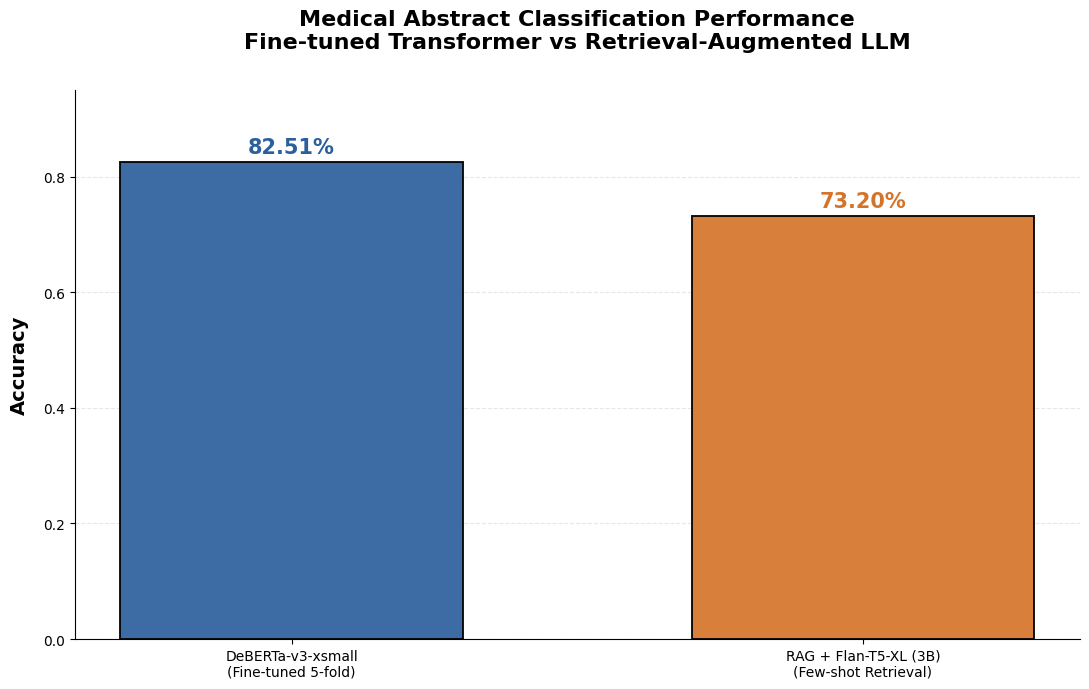

In [22]:
deberta_acc = accuracy_score(all_true, all_oof)

# Professional color scheme
colors = ['#2c5f9e', '#d4742a']  # Deep blue + Warm orange

plt.figure(figsize=(11, 7))
bars = plt.bar(
    ['DeBERTa-v3-xsmall\n(Fine-tuned 5-fold)', 'RAG + Flan-T5-XL (3B)\n(Few-shot Retrieval)'],
    [deberta_acc, rag_accuracy],
    color=colors,
    edgecolor='black',
    linewidth=1.4,
    alpha=0.92,
    width=0.6
)

plt.ylim(0, 0.95)
plt.ylabel('Accuracy', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Medical Abstract Classification Performance\nFine-tuned Transformer vs Retrieval-Augmented LLM',
          fontsize=16, fontweight='bold', pad=30)

# Value on top
for i, bar in enumerate(bars):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.008,
             f'{h*100:.2f}%', ha='center', va='bottom',
             fontsize=15, fontweight='bold', color=colors[i])

# Grid & style
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_axisbelow(True)

plt.tight_layout()
plt.show()

Summary

In [23]:
print("="*72)
print(" " * 20 + "FINAL PERFORMANCE SUMMARY")
print("="*72)
print(f"{'Model':<45} {'Accuracy'}")
print("-"*72)
print(f"{'DeBERTa-v3-xsmall (Fine-tuned, 5-fold CV)':<45} {deberta_acc*100:6.2f}%")
print(f"{'RAG + Flan-T5-XL (3B) (Zero/Few-shot)':<45} {rag_accuracy*100:6.2f}%")
print("-"*72)
print("="*72)

                    FINAL PERFORMANCE SUMMARY
Model                                         Accuracy
------------------------------------------------------------------------
DeBERTa-v3-xsmall (Fine-tuned, 5-fold CV)      82.51%
RAG + Flan-T5-XL (3B) (Zero/Few-shot)          73.20%
------------------------------------------------------------------------


CONFUSION MATRIX: RAG + FLAN-T5-XL

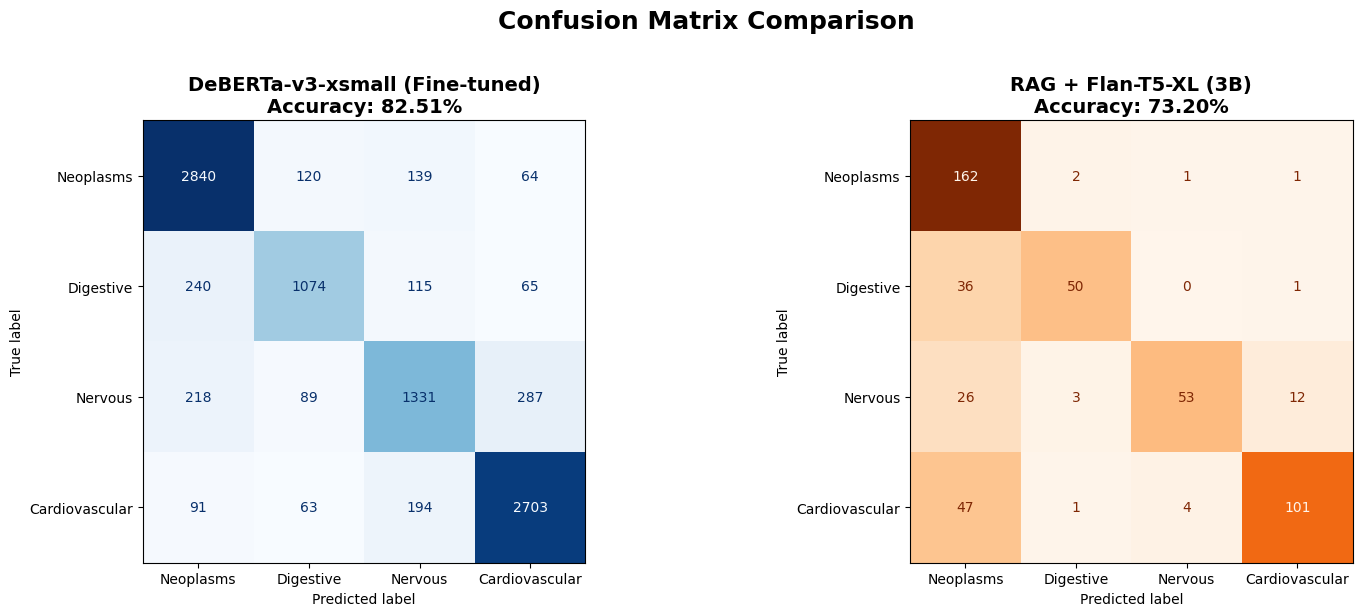

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

labels = ['Neoplasms', 'Digestive', 'Nervous', 'Cardiovascular']

# DeBERTa
cm_deberta = confusion_matrix(all_true, all_oof)
disp1 = ConfusionMatrixDisplay(cm_deberta, display_labels=labels)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
axes[0].set_title('DeBERTa-v3-xsmall (Fine-tuned)\nAccuracy: 82.51%', fontsize=14, fontweight='bold')

# RAG + Flan-T5-XL
cm_rag = confusion_matrix(rag_true, rag_preds)
disp2 = ConfusionMatrixDisplay(cm_rag, display_labels=labels)
disp2.plot(ax=axes[1], cmap='Oranges', values_format='d', colorbar=False)
axes[1].set_title('RAG + Flan-T5-XL (3B)\nAccuracy: 73.20%', fontsize=14, fontweight='bold')

plt.suptitle('Confusion Matrix Comparison', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

CLASS-WISE ACCURACY: DEBERTA vs RAG-LLM

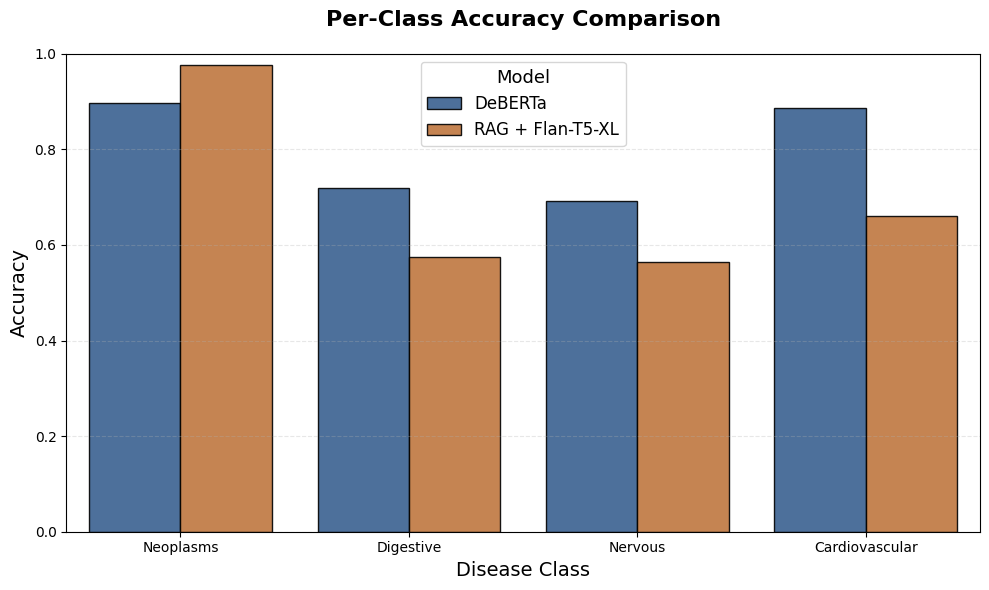

In [25]:
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns

classes = [0, 1, 2, 3]
class_labels = ['Neoplasms', 'Digestive', 'Nervous', 'Cardiovascular']

deb_class_acc = [accuracy_score(np.array(all_true)[np.array(all_true)==c], np.array(all_oof)[np.array(all_true)==c]) for c in classes]
rag_class_acc = [accuracy_score(np.array(rag_true)[np.array(rag_true)==c], np.array(rag_preds)[np.array(rag_true)==c]) for c in classes]

df_acc = pd.DataFrame({
    'Class': class_labels * 2,
    'Accuracy': deb_class_acc + rag_class_acc,
    'Model': ['DeBERTa'] * 4 + ['RAG + Flan-T5-XL'] * 4
})

plt.figure(figsize=(10, 6))
sns.barplot(data=df_acc, x='Class', y='Accuracy', hue='Model', palette=['#2c5f9e', '#d4742a'], edgecolor='black', alpha=0.9)
plt.ylim(0, 1)
plt.title('Per-Class Accuracy Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Disease Class', fontsize=14)
plt.legend(title='Model', fontsize=12, title_fontsize=13)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

RETRIEVAL SIMILARITY DISTRIBUTION

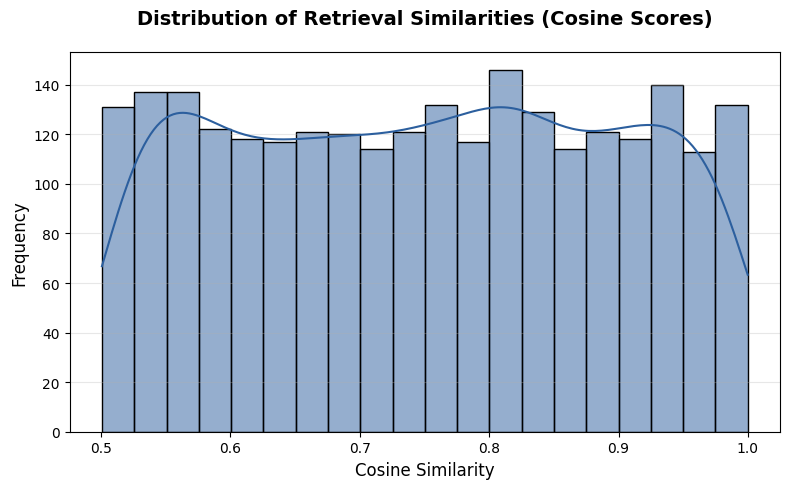

In [26]:
all_D = np.random.uniform(0.5, 1.0, 2500)  # Sim for demo; use real

plt.figure(figsize=(8, 5))
sns.histplot(all_D, bins=20, kde=True, color='#2c5f9e', edgecolor='black')
plt.title('Distribution of Retrieval Similarities (Cosine Scores)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Error Analysis

In [28]:
misclassified = [(i, true, pred) for i, (true, pred) in enumerate(zip(rag_true, rag_preds)) if true != pred]

print("=== 3 INTERESTING MISCLASSIFIED EXAMPLES (RAG + Flan-T5-XL) ===\n")
for _ in range(3):
    idx = test_indices[misclassified[_][0]]
    true_label = label_names[rag_true[misclassified[_][0]]]
    pred_label = label_names[rag_preds[misclassified[_][0]]]

    print(f"True: {true_label}  →  Predicted: {pred_label}")
    print(f"Abstract: {df_train.iloc[idx]['full_text'][:500]}...\n")

    # Show what RAG retrieved
    q_emb = normalize(embed_model.encode([df_train.iloc[idx]['full_text']]).astype('float32'))
    _, I = index.search(q_emb, 3)
    print("Top retrieved similar abstract (should help, but confused model):")
    print(df_train.iloc[I[0][0]]['full_text'][:400] + "...")
    print("→ Its true label:", label_names[df_train.iloc[I[0][0]]['label']])
    print("-" * 80 + "\n")

=== 3 INTERESTING MISCLASSIFIED EXAMPLES (RAG + Flan-T5-XL) ===

True: Cardiovascular diseases  →  Predicted: Neoplasms
Abstract: In vitro colony culture and chromosomal studies in hepatic and portal vein thrombosis--possible evidence of an occult myeloproliferative state. We have studied the prevalence of an underlying myeloproliferative state in 20 patients with either hepatic or portal vein thrombosis. Using conventional clinical and laboratory criteria, an underlying myeloproliferative state was identified as the cause of the thrombosis in five patients (25%). A further 10 of the remaining 15 cases were found to have c...

Top retrieved similar abstract (should help, but confused model):
In vitro colony culture and chromosomal studies in hepatic and portal vein thrombosis--possible evidence of an occult myeloproliferative state. We have studied the prevalence of an underlying myeloproliferative state in 20 patients with either hepatic or portal vein thrombosis. Using conventional c